In [ ]:
# скачиваем файл датасета
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1rwQRsjsUgJjFYJH5OhkzOC7PeezZhdEl' -O heart.csv

In [ ]:
!pip install scikit-learn==0.22.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
data = pd.read_csv('heart.csv')
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


Разделим данную выборку на обучающую и тестовую части.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.drop('target', axis=1), data['target'], test_size=0.25)
X_train.shape, X_test.shape

((227, 13), (76, 13))

Использовано решающее дерево из `sklearn` (`sklearn.tree.DecisionTreeClassifier`) без ограничения на максимальную глубину (`max_depth=None`).

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt

In [ ]:
dt = DecisionTreeClassifier(max_depth=None)
dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score
accuracy_score(y_train, dt.predict(X_train))

1.0

In [ ]:
accuracy_score(y_test, dt.predict(X_test))

0.7631578947368421

Перербор с помощью кросс-валидации оптимальные гиперпараметры алгоритма.
- `max_depth`: [3, 4, 5, 6, 7, 8, 9, 10, None]
- `max_features`: ['auto', 'log2', None]
- `min_samples_leaf`: range(1, 10)
- `min_samples_split`: range(2, 10)
- `criterion`: ['gini', 'entropy']


In [ ]:
dt = DecisionTreeClassifier()
param_grid = {'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, None],
              'max_features': ['auto', 'log2', None],
              'min_samples_leaf': range(1, 10),
              'min_samples_split': range(2, 10),
              'criterion': ['gini', 'entropy']}

In [ ]:
grid_dt = GridSearchCV(dt, param_grid, cv=5, scoring='accuracy')

In [ ]:
grid_dt.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                   

Доля правильных ответов решающего дерева с подобранными оптимальными значениями гиперпараметров на обучающей и тестовой выборке.

In [ ]:
grid_dt.best_params_

{'criterion': 'entropy',
 'max_depth': 7,
 'max_features': 'log2',
 'min_samples_leaf': 8,
 'min_samples_split': 8}

In [ ]:
grid_dt.best_score_

In [ ]:
accuracy_score(y_train, grid_dt.best_estimator_.predict(X_train))

0.8414096916299559

In [ ]:
accuracy_score(y_test, grid_dt.best_estimator_.predict(X_test))

0.7236842105263158

In [ ]:
best = grid_dt.best_estimator_

In [ ]:
yt_prob = best.predict_proba(X_test)

In [ ]:
best.classes_

array([0, 1])

In [ ]:
roc_auc_score(y_test, yt_prob[:,1])

0.7450980392156863

In [ ]:
pd.DataFrame({
    'feature': X_train.columns,
    'importance': best.feature_importances_
}).sort_values(by='importance', ascending=False).reset_index(drop=True)

,feature,importance
0,exang,0.277420
1,oldpeak,0.183897
2,thal,0.142082
3,thalach,0.116196
4,ca,0.081320
5,age,0.059533
6,chol,0.055917
7,trestbps,0.047374
8,cp,0.036261
9,sex,0.000000


In [ ]:
fpr, tpr, treshold = roc_curve(y_test, yt_prob[:,1])
roc_auc = auc(fpr, tpr)

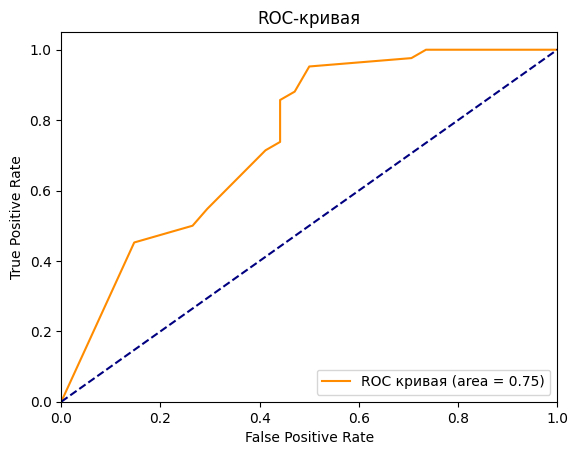

In [ ]:
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()